<a href="https://colab.research.google.com/github/shreya0505/BTP_7thSem/blob/main/MNIST_FMNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf; tf.compat.v1.disable_eager_execution()
from keras import backend as K
from keras.layers import Input, Dense, Conv2D, Conv2DTranspose, Flatten, Lambda, Reshape
from keras.models import Model
from keras.losses import binary_crossentropy
from keras.datasets import mnist, fashion_mnist
from keras.callbacks import ModelCheckpoint
from google.colab import files

In [ ]:
np.random.seed(25)
tf.executing_eagerly()

False

In [ ]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()

11501568/11490434 [==============================] - 0s 0us/step


In [ ]:
# A function to display image sequence
def display_image_sequence(x_start, y_start, x_end, y_end, no_of_imgs):
    x_axis = np.linspace(x_start,x_end,no_of_imgs)
    y_axis = np.linspace(y_start,y_end,no_of_imgs)
    
    x_axis = x_axis[:, np.newaxis]
    y_axis = y_axis[:, np.newaxis]
    
    new_points = np.hstack((x_axis, y_axis))
    new_images = decoder.predict(new_points)
    new_images = new_images.reshape(new_images.shape[0], new_images.shape[1], new_images.shape[2])
    
    # Display some images
    fig, axes = plt.subplots(ncols=no_of_imgs, sharex=False,
                             sharey=True, figsize=(20, 7))
    counter = 0
    for i in range(no_of_imgs):
        axes[counter].imshow(new_images[i], cmap='gray')
        axes[counter].get_xaxis().set_visible(False)
        axes[counter].get_yaxis().set_visible(False)
        counter += 1
    plt.show()



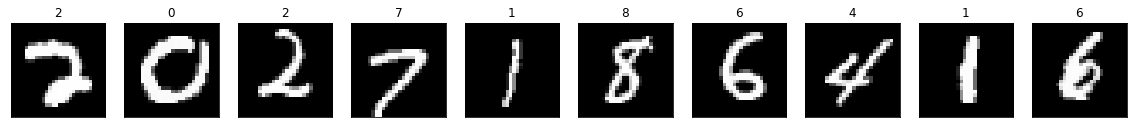

In [ ]:
# Loading dataset
(X_train, y_train), (X_test, y_test) = mnist.load_data()

# Displaying 120th to 129th data
fig, axes = plt.subplots(ncols=10, sharex=False,
    sharey=True, figsize=(20, 7))
counter = 0
for i in range(120, 130):
    axes[counter].set_title(y_train[i])
    axes[counter].imshow(X_train[i], cmap='gray')
    axes[counter].get_xaxis().set_visible(False)
    axes[counter].get_yaxis().set_visible(False)
    counter += 1
plt.show()

In [ ]:
# Normalize values such that all numbers are within
# the range of 0 to 1

X_train = X_train/255
X_test = X_test/255

In [ ]:
# Convert from (no_of_data, 28, 28) to (no_of_data, 28, 28, 1)
X_train_new = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2], 1)
X_test_new = X_test.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2], 1)
print("Previous:")
print(X_train.shape)
print(X_test.shape)
print("Current:")
print(X_train_new.shape)
print(X_test_new.shape)

Previous:
(60000, 28, 28)
(10000, 28, 28)
Current:
(60000, 28, 28, 1)
(10000, 28, 28, 1)


In [ ]:
# Defining some variables
img_height   = X_train_new.shape[1]    # 28
img_width    = X_train_new.shape[2]    # 28
num_channels = X_train_new.shape[3]    # 1
input_shape =  (img_height, img_width, num_channels)   # (28,28,1)
latent_dim = 2    # Dimension of the latent space

In [ ]:
# Constructing encoder
encoder_input = Input(shape=input_shape)

encoder_conv = Conv2D(filters=8, kernel_size=3, strides=2, 
                padding='same', activation='relu')(encoder_input)
encoder_conv = Conv2D(filters=16, kernel_size=3, strides=2, 
                padding='same', activation='relu')(encoder_input)
encoder = Flatten()(encoder_conv)

mu = Dense(latent_dim)(encoder)
sigma = Dense(latent_dim)(encoder)

In [ ]:
# A function to compute the value of latent space
def compute_latent(x):
    mu, sigma = x
    batch = K.shape(mu)[0]
    dim = K.int_shape(mu)[1]
    eps = K.random_normal(shape=(batch,dim))
    return mu + K.exp(sigma/2)*eps


In [ ]:
latent_space = Lambda(compute_latent, output_shape=(latent_dim,))([mu, sigma])


In [ ]:
# Take the convolution shape to be used in the decoder
conv_shape = K.int_shape(encoder_conv)
print(conv_shape)

(None, 14, 14, 16)


In [ ]:
# Constructing decoder
decoder_input = Input(shape=(latent_dim,))
decoder = Dense(conv_shape[1]*conv_shape[2]*conv_shape[3], activation='relu')(decoder_input)
decoder = Reshape((conv_shape[1], conv_shape[2], conv_shape[3]))(decoder)
decoder_conv = Conv2DTranspose(filters=16, kernel_size=3, strides=2, 
                           padding='same', activation='relu')(decoder)
decoder_conv = Conv2DTranspose(filters=8, kernel_size=3, strides=2, 
                           padding='same', activation='relu')(decoder)
decoder_conv =  Conv2DTranspose(filters=num_channels, kernel_size=3, 
                          padding='same', activation='sigmoid')(decoder_conv)

In [ ]:
# Actually build encoder, decoder and the entire VAE
encoder = Model(encoder_input, latent_space)
decoder = Model(decoder_input, decoder_conv)
vae = Model(encoder_input, decoder(encoder(encoder_input)))

In [ ]:
# The loss function for VAE
def kl_reconstruction_loss(true, pred):
    # Reconstruction loss (binary crossentropy)
    reconstruction_loss = binary_crossentropy(K.flatten(true), K.flatten(pred)) * img_width * img_height

    # KL divergence loss
    kl_loss = 1 + sigma - K.square(mu) - K.exp(sigma)
    kl_loss = K.sum(kl_loss, axis=-1)
    kl_loss *= -0.5
    # Total loss = 50% rec + 50% KL divergence loss
    return K.mean(reconstruction_loss + kl_loss)


In [ ]:
if not os.path.exists("/tmp/weights/mnist"):
  os.makedirs("/tmp/weights/mnist")

In [ ]:
# Compile the model using KL loss
vae.compile(optimizer='adam', loss=kl_reconstruction_loss)
mnist_checkpoint_vae = ModelCheckpoint(filepath= "/tmp/weights/mnist", save_weights_only = True, verbose=1)

In [ ]:
# Training VAE
history = vae.fit(x=X_train_new, y=X_train_new, epochs=60, batch_size=32, validation_data=(X_test_new,X_test_new),  callbacks=[mnist_checkpoint_vae])


Train on 60000 samples, validate on 10000 samples
Epoch 1/60
60000/60000 [==============================] - ETA: 0s - loss: 188.6928

/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2057: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates



Epoch 00001: saving model to /tmp/weights/mnist
60000/60000 [==============================] - 30s 497us/sample - loss: 188.6928 - val_loss: 170.1866
Epoch 2/60
59904/60000 [============================>.] - ETA: 0s - loss: 168.6824
Epoch 00002: saving model to /tmp/weights/mnist
60000/60000 [==============================] - 13s 225us/sample - loss: 168.6774 - val_loss: 167.5109
Epoch 3/60
59936/60000 [============================>.] - ETA: 0s - loss: 166.6169
Epoch 00003: saving model to /tmp/weights/mnist
60000/60000 [==============================] - 13s 224us/sample - loss: 166.6181 - val_loss: 166.2557
Epoch 4/60
59936/60000 [============================>.] - ETA: 0s - loss: 165.2575
Epoch 00004: saving model to /tmp/weights/mnist
60000/60000 [==============================] - 13s 224us/sample - loss: 165.2449 - val_loss: 164.6203
Epoch 5/60
59776/60000 [============================>.] - ETA: 0s - loss: 164.1742
Epoch 00005: saving model to /tmp/weights/mnist
60000/60000 [======

In [ ]:
!zip -r /content/mnist.zip /tmp/weights/mnist
files.download("/content/mnist.zip")

  adding: tmp/weights/mnist/ (stored 0%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

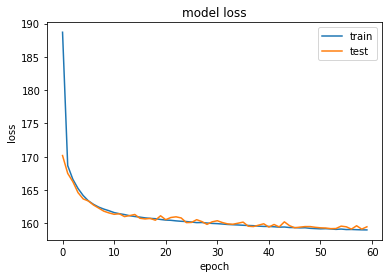

In [ ]:
# Plotting loss value decrease
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

In [ ]:
# Transform images to points in latent space using encoder
encoded = encoder.predict(X_train_new)

/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


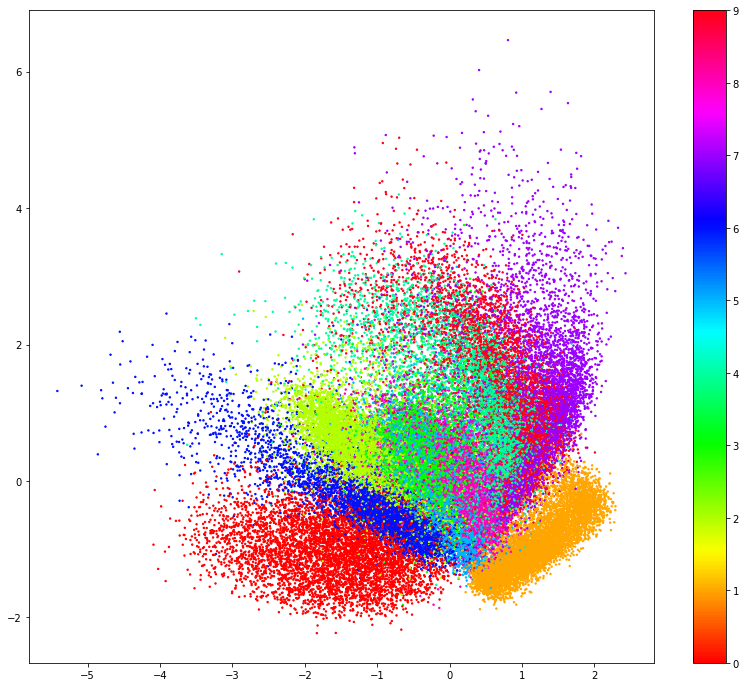

In [ ]:
# Displaying images in latent space
plt.figure(figsize=(14,12))
plt.scatter(encoded[:,0], encoded[:,1], s=2, c=y_train, cmap='hsv')
plt.colorbar()

In [ ]:
def display_image_sequence(x_start,y_start,x_end,y_end,no_of_imgs):
    x_axis = np.linspace(x_start,x_end,no_of_imgs)
    y_axis = np.linspace(y_start,y_end,no_of_imgs)
    
    x_axis = x_axis[:, np.newaxis]
    y_axis = y_axis[:, np.newaxis]
    
    new_points = np.hstack((x_axis, y_axis))
    print(new_points.shape)
    print(new_points)
    new_images = decoder.predict(new_points)
    new_images = new_images.reshape(new_images.shape[0], new_images.shape[1], new_images.shape[2])
    
    # Display some images
    fig, axes = plt.subplots(ncols=no_of_imgs, sharex=False,
                             sharey=True, figsize=(20, 7))
    counter = 0
    for i in range(no_of_imgs):
        axes[counter].imshow(new_images[i], cmap='gray')
        axes[counter].get_xaxis().set_visible(False)
        axes[counter].get_yaxis().set_visible(False)
        counter += 1
    plt.show()

(9, 2)
[[0.   2.  ]
 [0.25 1.75]
 [0.5  1.5 ]
 [0.75 1.25]
 [1.   1.  ]
 [1.25 0.75]
 [1.5  0.5 ]
 [1.75 0.25]
 [2.   0.  ]]


/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


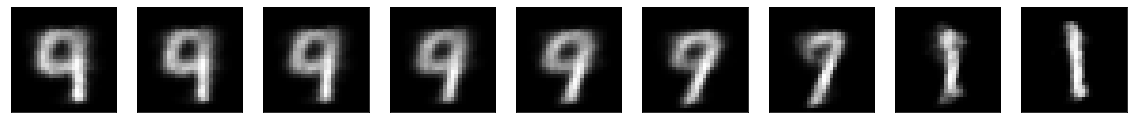

In [ ]:
# Starting point=(0,2), end point=(2,0)
display_image_sequence(0,2,2,0,9)

(9, 2)
[[-2.     1.   ]
 [-1.75   1.125]
 [-1.5    1.25 ]
 [-1.25   1.375]
 [-1.     1.5  ]
 [-0.75   1.625]
 [-0.5    1.75 ]
 [-0.25   1.875]
 [ 0.     2.   ]]


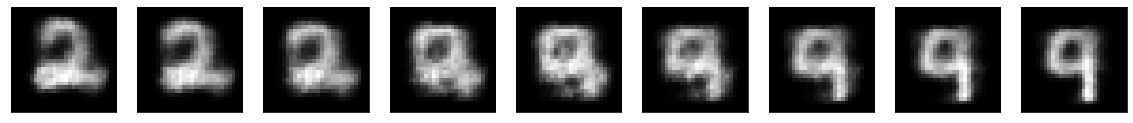

In [ ]:
# Starting point=(-2,1), end point=(0,2)
display_image_sequence(-2,1,0,2,9)

(19, 2)
[[ 0.         -2.        ]
 [ 0.         -1.77777778]
 [ 0.         -1.55555556]
 [ 0.         -1.33333333]
 [ 0.         -1.11111111]
 [ 0.         -0.88888889]
 [ 0.         -0.66666667]
 [ 0.         -0.44444444]
 [ 0.         -0.22222222]
 [ 0.          0.        ]
 [ 0.          0.22222222]
 [ 0.          0.44444444]
 [ 0.          0.66666667]
 [ 0.          0.88888889]
 [ 0.          1.11111111]
 [ 0.          1.33333333]
 [ 0.          1.55555556]
 [ 0.          1.77777778]
 [ 0.          2.        ]]


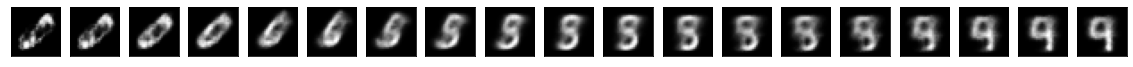

In [ ]:
# Starting point=(0,-2), end point=(0,2)
display_image_sequence(0,-2,0,2,19)

# **Fashion MNIST**

In [ ]:
(X_train_fashion, y_train_fashion), (X_test_fashion, y_test_fashion) = fashion_mnist.load_data()

4431872/4422102 [==============================] - 0s 0us/step


In [ ]:
# Normalize values such that all numbers are within
# the range of 0 to 1

X_train_fashion = X_train_fashion/255
X_test_fashion = X_test_fashion/255
# Convert from (no_of_data, 28, 28) to (no_of_data, 28, 28, 1)
X_train_fashion_new = X_train_fashion.reshape(X_train_fashion.shape[0], X_train_fashion.shape[1], X_train_fashion.shape[2], 1)
X_test_fashion_new = X_test_fashion.reshape(X_test_fashion.shape[0], X_test_fashion.shape[1], X_test_fashion.shape[2], 1)

In [ ]:
# Actually build encoder, decoder and the entire VAE
fencoder = Model(encoder_input, latent_space)
fdecoder = Model(decoder_input, decoder_conv)
fvae = Model(encoder_input, fdecoder(fencoder(encoder_input)))



In [ ]:
if not os.path.exists("/tmp/weights/fmnist"):
  os.makedirs("/tmp/weights/fmnist")

In [ ]:
fvae.compile(optimizer='adam', loss=kl_reconstruction_loss)
fmnist_checkpoint_vae = ModelCheckpoint(filepath= "/tmp/weights/fmnist", save_weights_only = True, verbose=1)
history = fvae.fit(x=X_train_fashion_new, y=X_train_fashion_new, epochs=100, batch_size=32, validation_data=(X_test_fashion_new,X_test_fashion_new), callbacks=[fmnist_checkpoint_vae] )


Train on 60000 samples, validate on 10000 samples
Epoch 1/100
59936/60000 [============================>.] - ETA: 0s - loss: 303.7099

/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2057: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates



Epoch 00001: saving model to /tmp/weights/fmnist
60000/60000 [==============================] - 25s 415us/sample - loss: 303.6989 - val_loss: 282.0615
Epoch 2/100
59936/60000 [============================>.] - ETA: 0s - loss: 277.8118
Epoch 00002: saving model to /tmp/weights/fmnist
60000/60000 [==============================] - 23s 386us/sample - loss: 277.8235 - val_loss: 277.1388
Epoch 3/100
59840/60000 [============================>.] - ETA: 0s - loss: 274.6859
Epoch 00003: saving model to /tmp/weights/fmnist
60000/60000 [==============================] - 20s 327us/sample - loss: 274.6938 - val_loss: 275.4768
Epoch 4/100
60000/60000 [==============================] - ETA: 0s - loss: 273.1494
Epoch 00004: saving model to /tmp/weights/fmnist
60000/60000 [==============================] - 22s 360us/sample - loss: 273.1494 - val_loss: 274.2887
Epoch 5/100
59936/60000 [============================>.] - ETA: 0s - loss: 272.2958
Epoch 00005: saving model to /tmp/weights/fmnist
60000/6000

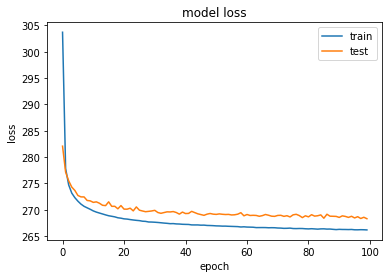

In [ ]:
# Plotting loss value decrease
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

In [ ]:
!zip -r /content/fmnist.zip /tmp/weights/fmnist
files.download("/content/fmnist.zip")

  adding: tmp/weights/fmnist/ (stored 0%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
encoded = fencoder.predict(X_train_fashion_new)

/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


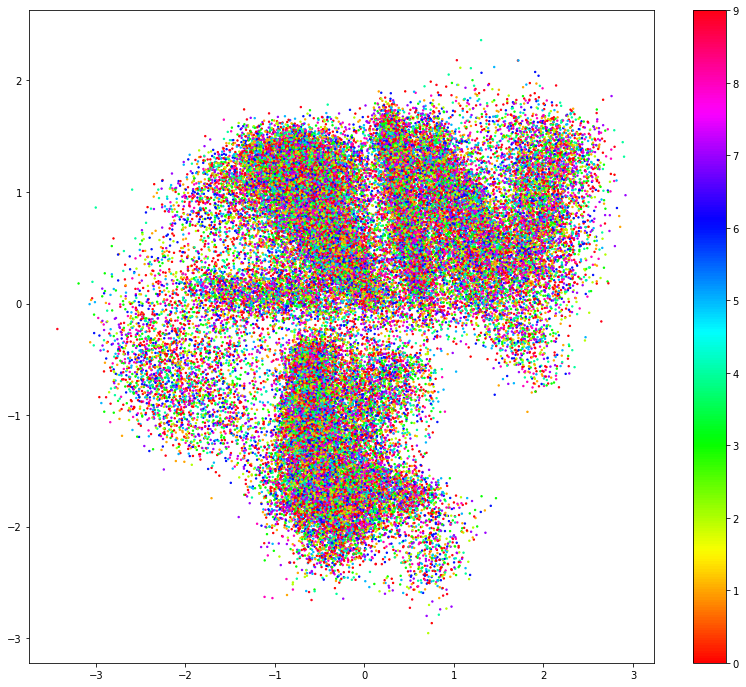

In [ ]:
# Displaying images in latent space
plt.figure(figsize=(14,12))
plt.scatter(encoded[:,0], encoded[:,1], s=2, c=y_train, cmap='hsv')
plt.colorbar()

(9, 2)
[[0.   2.  ]
 [0.25 1.75]
 [0.5  1.5 ]
 [0.75 1.25]
 [1.   1.  ]
 [1.25 0.75]
 [1.5  0.5 ]
 [1.75 0.25]
 [2.   0.  ]]


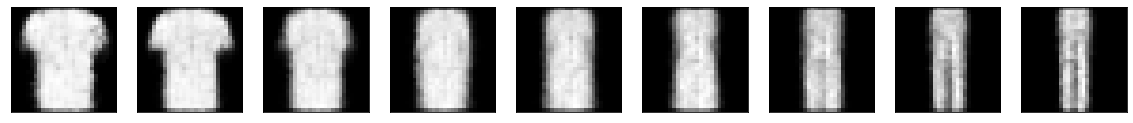

In [ ]:
display_image_sequence(0,2,2,0,9)

In [ ]:
https://github.com/willtai/vae_exploration/blob/master/notebooks/fashion_mnist_vae.ipynb